# Our Faces Diffusion

### Envrionment Set Up

In [1]:
!pip install -U diffusers[training] #in case collab resets

In [2]:
!pip install -U datasets huggingface_hub fsspec


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.1/512.1 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 70.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.31.4
    Uninstalling huggingface-hub-0.31.4:
      Successfully uninstalled huggingface-hub-0.31.4
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency c

In [ ]:
from datasets import load_dataset
from huggingface_hub import notebook_login

notebook_login()

#!sudo apt -qq install git-lfs
#!git config --global credential.helper store

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')


## Loading the Dataset

In [ ]:
# REMOVE any old copy
#!rm -rf /content/EuroSAT

# COPY cleanly
#!cp -r /content/drive/MyDrive/data/eurosat-dataset/6/EuroSAT /content/
#!cp -r Our-Faces.zip /content/



In [ ]:
import os
os.getcwd()
import zipfile
import os
import shutil

zip_path = "./Our-Faces.zip"  # path to the zip file
target_dir = "./data/"  # extraction and loading directory


# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_dir)
    print(f"✅ Extracted '{zip_path}' into '{target_dir}/'")



dataset = load_dataset(
    "imagefolder",
    data_dir="./data/Our-Faces"
)

dataset

✅ Extracted './Our-Faces.zip' into './data//'


Resolving data files:   0%|          | 0/5497 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5497
    })
})

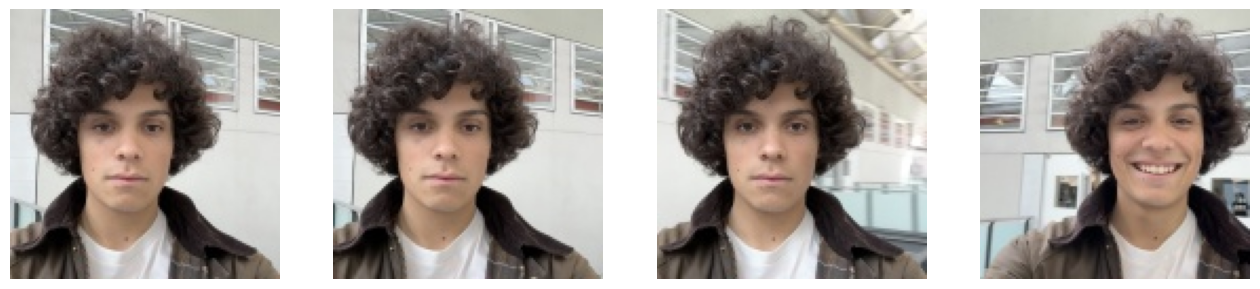

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset["train"][:4]["image"]):  # Access images from the train set
    axs[i].imshow(image)
    axs[i].set_axis_off()
fig.show()


In [5]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 24
    eval_batch_size = 24  # how many images to sample during evaluation
    num_epochs = 50
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 50
    save_image_epochs = 10
    save_model_epochs = 30
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'ddpm-our-faces_conditional'  # the model namy locally and on the HF Hub

    push_to_hub = True  # whether to upload the saved model to the HF Hub
    hub_private_repo = False
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

### Preprocessing for Diffusion

In [6]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    labels = examples["label"]  # <- Keep the labels
    return {"images": images, "label": labels}
# Apply the batch transform to your dataset
dataset.set_transform(transform)

NameError: name 'dataset' is not defined

In [ ]:
dataset["train"]

Dataset({
    features: ['image', 'label'],
    num_rows: 5497
})

## Configuration and Dataloader

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5497
    })
})

In [7]:
import torch

import torch

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"],
    batch_size=config.train_batch_size,   # ⚡ BIG BATCH
    shuffle=True,
    num_workers=12,    # ⚡ MORE WORKERS
    pin_memory=True,  # ⚡ FAST CPU → GPU transfer
)

NameError: name 'dataset' is not defined

In [8]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
      ),
    num_class_embeds=3,
)

In [ ]:
sample_image = dataset["train"][0]["images"].unsqueeze(0)  # ✅ Correct for your dataset
sample_image.shape  # Should print (1, 3, 128, 128)

torch.Size([1, 3, 128, 128])

In [ ]:
#model(sample_image, timestep=0, class_label = 3).sample.shape

## Defining the noise scheduler

In [9]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

In [ ]:
print(dataset['train'])  # if you have a 'train' split

Dataset({
    features: ['image', 'label'],
    num_rows: 5497
})


In [10]:
import torch
from PIL import Image

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

NameError: name 'sample_image' is not defined

In [ ]:
#import torch.nn.functional as F

#noise_pred = model(noisy_image, timesteps).sample
#loss = F.mse_loss(noise_pred, noise)

## Training

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)



NameError: name 'train_dataloader' is not defined

In [ ]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size,
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

### Loading the HuggingFace model to continue training:

This fetches the model so we have the model locally to continue training!

### Training Loop:

In [13]:
from huggingface_hub import snapshot_download

# Download model folder from the Hub (only once)
snapshot_download(
    repo_id="otausendschoen/ddpm-our-faces_conditional_2",
    local_dir="ddpm-our-faces_conditional",  # must match `config.output_dir`
    repo_type="model",
    local_dir_use_symlinks=False
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:980: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a local folder has been updated and do not rely on symlinks anymore. You only need to pass a destination folder as`local_dir`.
For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/download#download-files-to-local-folder.
  warnings.warn(


Fetching 120 files:   0%|          | 0/120 [00:00<?, ?it/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.8k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

loss_plot_epoch_1.png:   0%|          | 0.00/32.5k [00:00<?, ?B/s]

loss_plot_epoch_104.png:   0%|          | 0.00/38.4k [00:00<?, ?B/s]

loss_plot_epoch_109.png:   0%|          | 0.00/38.8k [00:00<?, ?B/s]

loss_plot_epoch_114.png:   0%|          | 0.00/38.9k [00:00<?, ?B/s]

loss_plot_epoch_119.png:   0%|          | 0.00/39.0k [00:00<?, ?B/s]

loss_plot_epoch_124.png:   0%|          | 0.00/39.4k [00:00<?, ?B/s]

loss_plot_epoch_129.png:   0%|          | 0.00/40.1k [00:00<?, ?B/s]

loss_plot_epoch_134.png:   0%|          | 0.00/40.2k [00:00<?, ?B/s]

loss_plot_epoch_139.png:   0%|          | 0.00/40.8k [00:00<?, ?B/s]

loss_plot_epoch_144.png:   0%|          | 0.00/40.8k [00:00<?, ?B/s]

loss_plot_epoch_14.png:   0%|          | 0.00/34.5k [00:00<?, ?B/s]

loss_plot_epoch_149.png:   0%|          | 0.00/40.8k [00:00<?, ?B/s]

loss_plot_epoch_151.png:   0%|          | 0.00/41.1k [00:00<?, ?B/s]

loss_plot_epoch_19.png:   0%|          | 0.00/37.0k [00:00<?, ?B/s]

loss_plot_epoch_24.png:   0%|          | 0.00/35.8k [00:00<?, ?B/s]

loss_plot_epoch_34.png:   0%|          | 0.00/37.2k [00:00<?, ?B/s]

loss_plot_epoch_39.png:   0%|          | 0.00/37.4k [00:00<?, ?B/s]

loss_plot_epoch_29.png:   0%|          | 0.00/36.4k [00:00<?, ?B/s]

loss_plot_epoch_44.png:   0%|          | 0.00/37.5k [00:00<?, ?B/s]

loss_plot_epoch_49.png:   0%|          | 0.00/37.6k [00:00<?, ?B/s]

loss_plot_epoch_4.png:   0%|          | 0.00/34.5k [00:00<?, ?B/s]

loss_plot_epoch_54.png:   0%|          | 0.00/38.0k [00:00<?, ?B/s]

loss_plot_epoch_64.png:   0%|          | 0.00/38.4k [00:00<?, ?B/s]

loss_plot_epoch_74.png:   0%|          | 0.00/38.8k [00:00<?, ?B/s]

loss_plot_epoch_69.png:   0%|          | 0.00/38.6k [00:00<?, ?B/s]

loss_plot_epoch_59.png:   0%|          | 0.00/37.8k [00:00<?, ?B/s]

loss_plot_epoch_79.png:   0%|          | 0.00/39.0k [00:00<?, ?B/s]

loss_plot_epoch_84.png:   0%|          | 0.00/39.2k [00:00<?, ?B/s]

loss_plot_epoch_9.png:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

loss_plot_epoch_94.png:   0%|          | 0.00/37.4k [00:00<?, ?B/s]

loss_plot_epoch_89.png:   0%|          | 0.00/37.5k [00:00<?, ?B/s]

loss_plot_epoch_99.png:   0%|          | 0.00/38.3k [00:00<?, ?B/s]

'/content/ddpm-our-faces_conditional'

In [ ]:
from accelerate import Accelerator
from accelerate.utils import ProjectConfiguration
from huggingface_hub import create_repo, upload_folder
from tqdm.auto import tqdm
from pathlib import Path
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from diffusers import DDPMPipeline

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # ======================================================
    # Initialize accelerator and tensorboard logging
    logging_dir = os.path.join(config.output_dir, "logs")
    accelerator_project_config = ProjectConfiguration(project_dir=config.output_dir, logging_dir=logging_dir)
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
        log_with="tensorboard",
        project_config=accelerator_project_config,
    )
    accelerator.init_trackers("ddpm-eurosat-conditional", init_kwargs={"wandb": {"resume": "allow"}})
    #accelerator.init_trackers("ddpm-eurosat-conditional")
    # ======================================================

    # Prepare everything (model, optimizer, scheduler, dataloader)
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    if accelerator.is_main_process:
        repo_id = None  # important: always define repo_id

        if config.push_to_hub:
            repo_id = create_repo(
                repo_id=Path(config.output_dir).name, exist_ok=True
            ).repo_id
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)

    global_step = 0
    epoch_losses = []

    # ======================================================
    # RESUME FROM LOCAL CHECKPOINT
    latest_checkpoint = None
    output_dir = Path(config.output_dir)
    checkpoints = sorted(output_dir.glob("checkpoint_epoch_*"), key=lambda p: int(p.name.split("_")[-1]))
    if checkpoints:
        latest_checkpoint = checkpoints[-1]

    if latest_checkpoint:
        print(f"Resuming from checkpoint: {latest_checkpoint}")
        accelerator.load_state(str(latest_checkpoint))
    # ======================================================

    if accelerator.is_main_process:
        print(f"  Starting training with the following configuration:")
        print(f"   - Number of epochs: {config.num_epochs}")
        print(f"   - Batch size: {config.train_batch_size}")
        print(f"   - Mixed precision: {config.mixed_precision}")
        print(f"   - Output directory: {config.output_dir}")
        print(f"   - Number of training samples: {len(train_dataloader.dataset)}")

    # ======================================================
    # Start training loop
    start_epoch = 0
    if latest_checkpoint:
    # extract last saved epoch number from folder name: checkpoint_epoch_X
      start_epoch = int(latest_checkpoint.name.split("_")[-1]) + 1
    for epoch in range(start_epoch, start_epoch + config.num_epochs):
    #for epoch in range(config.num_epochs):
        model.train()
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        epoch_loss = 0.0
        batches_in_epoch = len(train_dataloader)

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            labels = batch['label']

            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]
            timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device).long()

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps, class_labels=labels, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            epoch_loss += loss.detach().item()

            progress_bar.update(1)
            logs = {
                "loss": loss.detach().item(),
                "lr": lr_scheduler.get_last_lr()[0],
                "step": global_step,
                "avg_loss": epoch_loss / (step + 1)
            }
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # End of epoch
        avg_epoch_loss = epoch_loss / batches_in_epoch
        epoch_losses.append(avg_epoch_loss)

        if accelerator.is_main_process:
            print(f"\n Epoch {epoch} completed. Average loss: {avg_epoch_loss:.4f}")
            final_epoch = start_epoch + config.num_epochs - 1

            # ======================
            # Save loss plot
            if (epoch + 1) % 5 == 0 or epoch == final_epoch:
                plt.figure(figsize=(10, 6))
                plt.plot(range(len(epoch_losses)), epoch_losses, marker='o')
                plt.title('Training Loss Over Epochs')
                plt.xlabel('Epoch')
                plt.ylabel('Average Loss')
                plt.grid(True)
                loss_plot_path = os.path.join(config.output_dir, f"loss_plot_epoch_{epoch}.png")
                os.makedirs(os.path.dirname(loss_plot_path), exist_ok=True)  # ✅ Make sure dir exists
                plt.savefig(loss_plot_path)
                plt.close()
                print(f" Loss plot saved to {loss_plot_path}")
            # ======================

            # ======================
            # 🧹 Save full checkpoint (model + optimizer + scheduler)
            if (epoch + 1) % 5 == 0 or epoch == (start_epoch + config.num_epochs) - 1:
                checkpoint_dir = os.path.join(config.output_dir, f"checkpoint_epoch_{epoch}")
                accelerator.save_state(checkpoint_dir)
                print(f"Checkpoint saved to {checkpoint_dir}")
            # ======================

            # ======================
            # 🖼️ Save generated images
            '''
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                print(f" Generating sample images for epoch {epoch}...")
                evaluate(config, epoch, pipeline)
            # ======================
            '''
            # ======================
            # 💾 Save full model
            if epoch == final_epoch:
                print(f" Saving model for epoch {epoch}...")
                #pipeline.save_pretrained(config.output_dir)
                accelerator.unwrap_model(model).save_pretrained(config.output_dir)
                if config.push_to_hub:
                    upload_folder(
                        repo_id=repo_id,
                        folder_path=config.output_dir,
                        commit_message=f"Epoch {epoch}",
                        ignore_patterns=["step_*"],#include ,"epoch_*" to safe space on huggingface
                    )
                print(f" Model saved successfully!")
            # ======================


## Let's train

In [ ]:
from torch.utils.data import DataLoader

# Ensure the "train" split is correctly accessed
train_dataloader = DataLoader(
    dataset["train"],  # Access the 'train' split
    batch_size=config.train_batch_size,  # Set batch size
    shuffle=True
)

print(dataset.keys())  # Check if 'train' exists as a key



dict_keys(['train'])


In [ ]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

#DO NOT RUN THIS IF NOT IN THE CORRECT REPO! EVERYTHING WILL GET OVERWRITTEN
notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.
Resuming from checkpoint: ddpm-our-faces_conditional/checkpoint_epoch_49
  Starting training with the following configuration:
   - Number of epochs: 50
   - Batch size: 24
   - Mixed precision: fp16
   - Output directory: ddpm-our-faces_conditional
   - Number of training samples: 5497


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 50 completed. Average loss: 0.0165


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 51 completed. Average loss: 0.0174


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 52 completed. Average loss: 0.0165


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 53 completed. Average loss: 0.0165


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 54 completed. Average loss: 0.0170
 Loss plot saved to ddpm-our-faces_conditional/loss_plot_epoch_54.png
Checkpoint saved to ddpm-our-faces_conditional/checkpoint_epoch_54


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 55 completed. Average loss: 0.0179


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 56 completed. Average loss: 0.0166


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 57 completed. Average loss: 0.0165


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 58 completed. Average loss: 0.0182


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 59 completed. Average loss: 0.0165
 Loss plot saved to ddpm-our-faces_conditional/loss_plot_epoch_59.png
Checkpoint saved to ddpm-our-faces_conditional/checkpoint_epoch_59


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 60 completed. Average loss: 0.0170


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 61 completed. Average loss: 0.0162


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 62 completed. Average loss: 0.0167


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 63 completed. Average loss: 0.0158


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 64 completed. Average loss: 0.0159
 Loss plot saved to ddpm-our-faces_conditional/loss_plot_epoch_64.png
Checkpoint saved to ddpm-our-faces_conditional/checkpoint_epoch_64


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 65 completed. Average loss: 0.0167


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 66 completed. Average loss: 0.0163


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 67 completed. Average loss: 0.0170


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 68 completed. Average loss: 0.0171


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 69 completed. Average loss: 0.0168
 Loss plot saved to ddpm-our-faces_conditional/loss_plot_epoch_69.png
Checkpoint saved to ddpm-our-faces_conditional/checkpoint_epoch_69


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 70 completed. Average loss: 0.0175


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 71 completed. Average loss: 0.0171


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 72 completed. Average loss: 0.0163


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 73 completed. Average loss: 0.0167


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 74 completed. Average loss: 0.0164
 Loss plot saved to ddpm-our-faces_conditional/loss_plot_epoch_74.png
Checkpoint saved to ddpm-our-faces_conditional/checkpoint_epoch_74


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 75 completed. Average loss: 0.0168


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 76 completed. Average loss: 0.0166


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 77 completed. Average loss: 0.0166


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 78 completed. Average loss: 0.0176


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 79 completed. Average loss: 0.0166
 Loss plot saved to ddpm-our-faces_conditional/loss_plot_epoch_79.png
Checkpoint saved to ddpm-our-faces_conditional/checkpoint_epoch_79


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 80 completed. Average loss: 0.0176


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 81 completed. Average loss: 0.0162


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 82 completed. Average loss: 0.0170


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 83 completed. Average loss: 0.0158


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 84 completed. Average loss: 0.0169
 Loss plot saved to ddpm-our-faces_conditional/loss_plot_epoch_84.png
Checkpoint saved to ddpm-our-faces_conditional/checkpoint_epoch_84


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 85 completed. Average loss: 0.0160


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 86 completed. Average loss: 0.0172


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 87 completed. Average loss: 0.0160


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 88 completed. Average loss: 0.0163


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 89 completed. Average loss: 0.0158
 Loss plot saved to ddpm-our-faces_conditional/loss_plot_epoch_89.png
Checkpoint saved to ddpm-our-faces_conditional/checkpoint_epoch_89


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 90 completed. Average loss: 0.0160


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 91 completed. Average loss: 0.0169


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 92 completed. Average loss: 0.0174


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 93 completed. Average loss: 0.0170


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 94 completed. Average loss: 0.0170
 Loss plot saved to ddpm-our-faces_conditional/loss_plot_epoch_94.png
Checkpoint saved to ddpm-our-faces_conditional/checkpoint_epoch_94


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 95 completed. Average loss: 0.0169


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 96 completed. Average loss: 0.0163


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 97 completed. Average loss: 0.0164


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 98 completed. Average loss: 0.0168


  0%|          | 0/230 [00:00<?, ?it/s]


 Epoch 99 completed. Average loss: 0.0169
 Loss plot saved to ddpm-our-faces_conditional/loss_plot_epoch_99.png
Checkpoint saved to ddpm-our-faces_conditional/checkpoint_epoch_99
 Saving model for epoch 99...


optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

Upload 53 LFS files:   0%|          | 0/53 [00:00<?, ?it/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

optimizer.bin:   0%|          | 0.00/910M [00:00<?, ?B/s]

random_states_0.pkl:   0%|          | 0.00/14.3k [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

scheduler.bin:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/455M [00:00<?, ?B/s]

events.out.tfevents.1748680025.becff46506b3.1690.0:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

events.out.tfevents.1748680308.becff46506b3.1690.1:   0%|          | 0.00/2.00M [00:00<?, ?B/s]

 Model saved successfully!


## Print the loss

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os

log_dir = os.path.join(config.output_dir, "logs", "ddpm-eurosat-conditional")  # adjust if needed
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

print("Available scalar tags:")
print(event_acc.Tags()["scalars"])


In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
import pandas as pd
import matplotlib.pyplot as plt


# Load TensorBoard log
event_acc = EventAccumulator(log_dir)
event_acc.Reload()

# Extract loss values
loss_events = event_acc.Scalars('loss')
steps = [e.step for e in loss_events]
losses = [e.value for e in loss_events]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(steps, losses, label='Training Loss')
plt.xlabel("Step")
plt.ylabel("loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.ylim(0,0.18)
plt.legend()
plt.show()


In [ ]:
import numpy as np

def smooth_curve(values, window_size=10):
    """Smooths values using a simple moving average."""
    return np.convolve(values, np.ones(window_size)/window_size, mode='valid')


smoothed_losses = smooth_curve(losses)

# For proper alignment with steps (same length)
steps_smoothed = steps[:len(smoothed_losses)]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(steps_smoothed, smoothed_losses, label='avg_loss (smoothed)', color='blue')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Smoothed Training Loss Over Steps")
plt.ylim(0, 0.18)
plt.grid(True)
plt.legend()
plt.show()



## Sample some images

In [14]:
from diffusers import DDPMPipeline

# Rebuild pipeline manually from your UNet + scheduler
pipeline = DDPMPipeline(unet=model, scheduler=noise_scheduler)

# Save it cleanly
#pipeline.save_pretrained("ddpm-eurosat-claudia")
#pipeline = DDPMPipeline.from_pretrained("ddpm-eurosat-claudia")
pipeline = pipeline.to("cuda")


In [15]:
import torch
from torchvision import transforms
import matplotlib.pyplot as plt

def generate_class_conditional_images(model, noise_scheduler, class_labels, image_size=64, seed=42):
    model.eval()
    batch_size = len(class_labels)
    generator = torch.Generator(device="cuda").manual_seed(seed)

    x = torch.randn(batch_size, 3, image_size, image_size, device="cuda", generator=generator)
    timesteps = torch.full((batch_size,), noise_scheduler.config.num_train_timesteps - 1, device="cuda", dtype=torch.long)#initializes the timesteps for all images as a torch array. eg (tensor([999, 999, 999, 999, 999, 999, 999, 999], device='cuda:0'))
    ##REVERSE DIFFUSION:
    for t in range(noise_scheduler.config.num_train_timesteps - 1, -1, -1): #loop through all timesteps, starting from intiial timestep(-1 to go backward)
        timesteps.fill_(t) #creates the tensore filled with the current timesteps so basically the same as above
        with torch.no_grad():
            noise_pred = model(x, timesteps, class_labels=class_labels).sample
        x = noise_scheduler.step(noise_pred, t, x).prev_sample

    return (x / 2 + 0.5).clamp(0, 1)  # return denormalized images


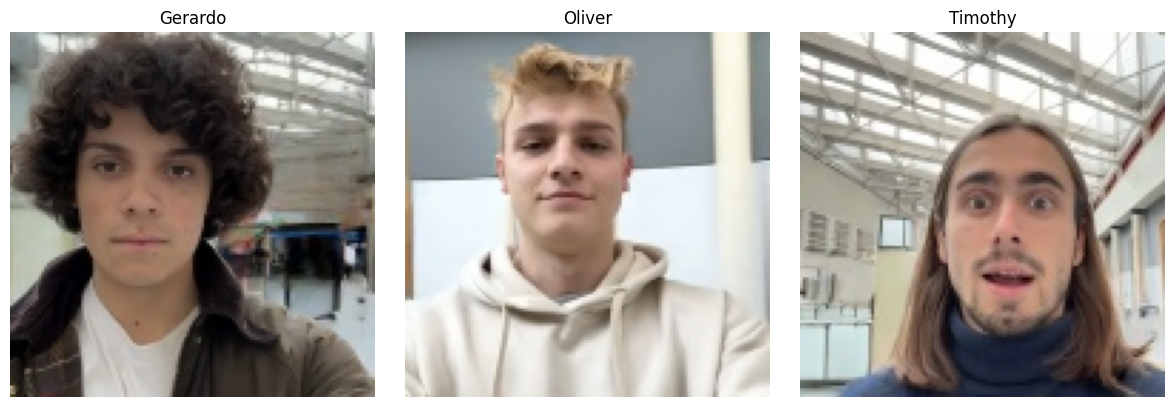

In [24]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from diffusers import UNet2DModel, DDPMScheduler

# Load trained model
model = UNet2DModel.from_pretrained("ddpm-our-faces_conditional").to("cuda")
model.eval()

# Rebuild scheduler manually (since you didn't save it)
scheduler = DDPMScheduler(num_train_timesteps=1000)

# Labels to generate
labels = torch.tensor([0, 1, 2], device="cuda")  # e.g., Gerardo, Oliver, Timothy
batch_size = len(labels)
image_size = 128  # same as training

# Start from random noise
x = torch.randn((batch_size, 3, image_size, image_size), device="cuda")

# Run reverse diffusion
with torch.no_grad():
    for t in reversed(range(scheduler.config.num_train_timesteps)):
        t_batch = torch.full((batch_size,), t, device="cuda", dtype=torch.long)
        noise_pred = model(x, t_batch, class_labels=labels).sample
        x = scheduler.step(noise_pred, t, x).prev_sample

# Denormalize and convert to PIL
x = (x / 2 + 0.5).clamp(0, 1)

# Plot results
fig, axs = plt.subplots(1, batch_size, figsize=(12, 4))
names = ['Gerardo', 'Oliver', 'Timothy']
for i in range(batch_size):
    img = transforms.ToPILImage()(x[i].cpu())
    axs[i].imshow(img)
    axs[i].set_title(names[labels[i].item()])
    axs[i].axis("off")
plt.tight_layout()
plt.savefig("generated_faces.png")
plt.show()
